In [4]:
import sys
import os

sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath('')), '..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [5]:
def get_cleaned_dataframe(csv_file_path):
    
    # read the csv file
    df = pd.read_csv(csv_file_path)
    boundary = False
    try:
        file_b = csv_file_path.replace("_attack", "_boundary_attack")
        df_b = pd.read_csv(file_b)
        boundary = True
    except Exception as e:
        pass

    # get only the relevant columns
    df = df[['Unnamed: 0', 'AugmentationAttack FP_MMPS', 'GapAttack FP_MMPS', 'RandomNoiseAttack FP_MMPS']]

    if boundary:
        df_b = df_b[['Unnamed: 0', 'DecisionBoundaryAttack FP_MMPS']]
        df_b.rename(columns={'DecisionBoundaryAttack FP_MMPS': 'Decision Boundary'}, inplace=True)
        df = pd.concat([df,df_b],ignore_index=True)

    df.rename(columns={'Unnamed: 0': 'Dataset','AugmentationAttack FP_MMPS': 'Data Augmentation', 'GapAttack FP_MMPS': 'Baseline', 'RandomNoiseAttack FP_MMPS': 'Random Noise'}, inplace=True)
    df.index = df['Dataset'].values.tolist()
    return df

def plot_dataframe(df1, figsize=(20, 15)):
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.barplot(
        x=df1['Dataset'],
        y=df1['FP_MMPS'],
        hue=df1['Attack'],
        alpha=1,
        palette=sns.color_palette("tab10")
    )
    ax.tick_params(axis='x', labelrotation=60, labelsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
    ax.tick_params(axis='y', labelsize=20)

    ax.xaxis.label.set_size(25) 
    ax.yaxis.label.set_size(25)
    ax.xaxis.label.set_weight('bold')
    ax.yaxis.label.set_weight('bold')

    for tick_label in ax.get_xticklabels():
        tick_label.set_fontweight('bold')

    for tick_label in ax.get_yticklabels():
        tick_label.set_fontweight('bold')

    ax.set_ylim([0.7, 1])
    if np.min(df1["FP_MMPS"]) > 0.97:
        ax.set_ylim([0.97,1])
    
    #ax.yaxis.set_ticks(np.arange(0, 1.1, 0.2))
    ax.grid(True)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, loc="center left", prop={'weight':'bold', 'size':23}, frameon=True, labelspacing=0.05, borderpad=0.2, borderaxespad=0.0, framealpha=1, handletextpad=0.2)

    # remove the unnecessary x label
    plt.xlabel("")

    plt.tight_layout()

    return ax

resnet18
salem_cnn_relu
efficient_net
efficient_net_LS


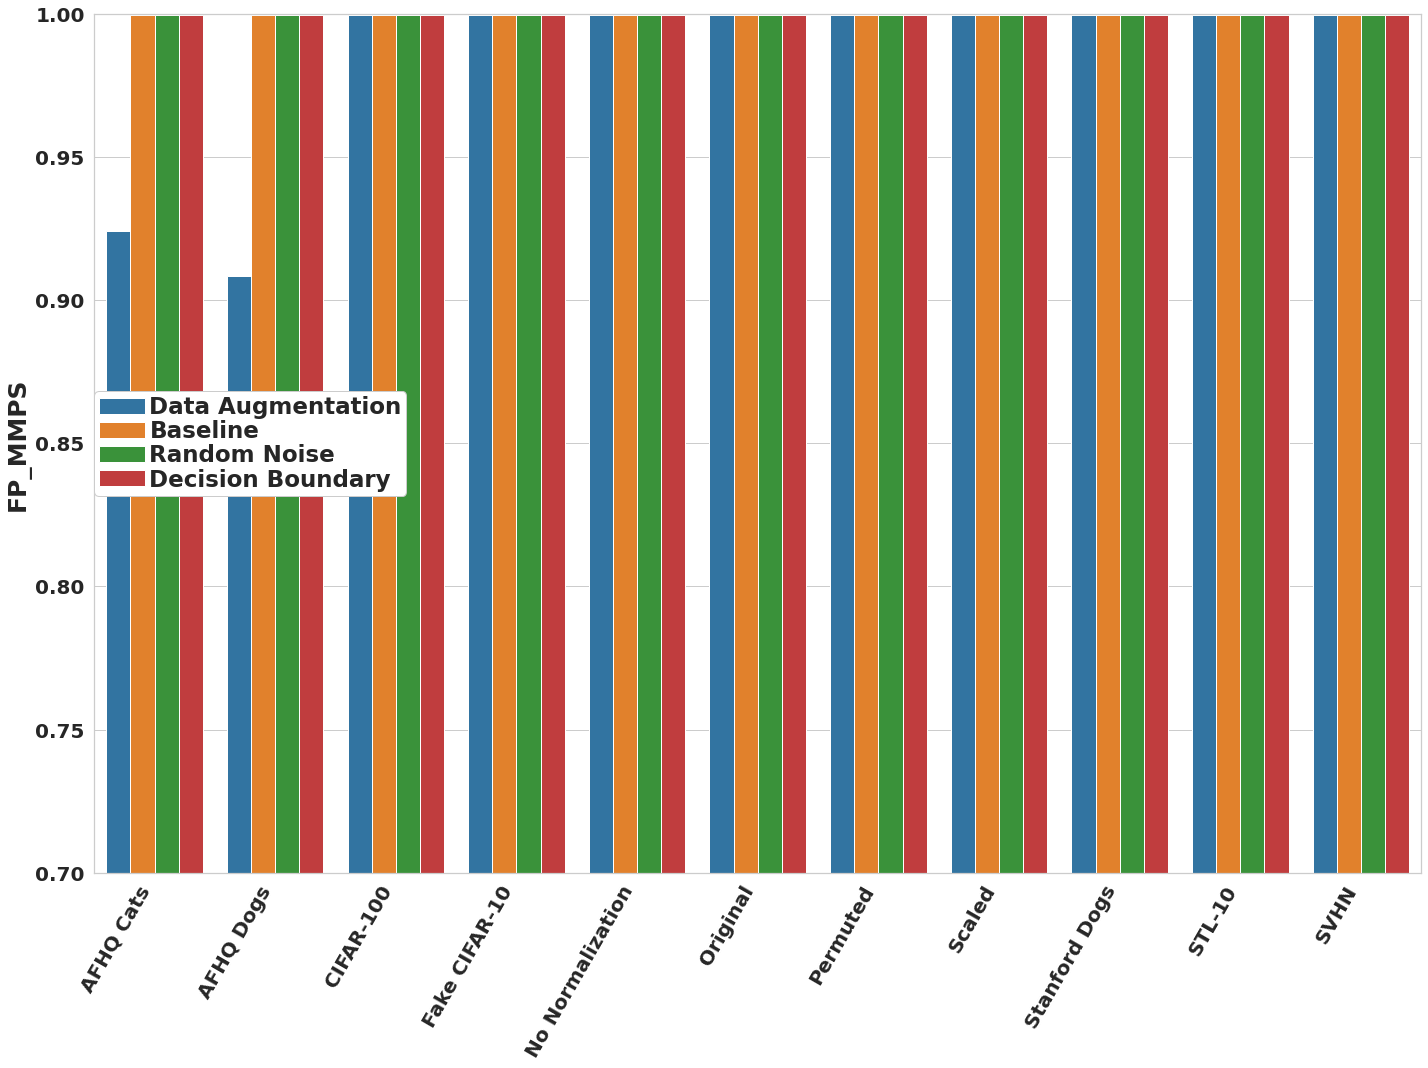

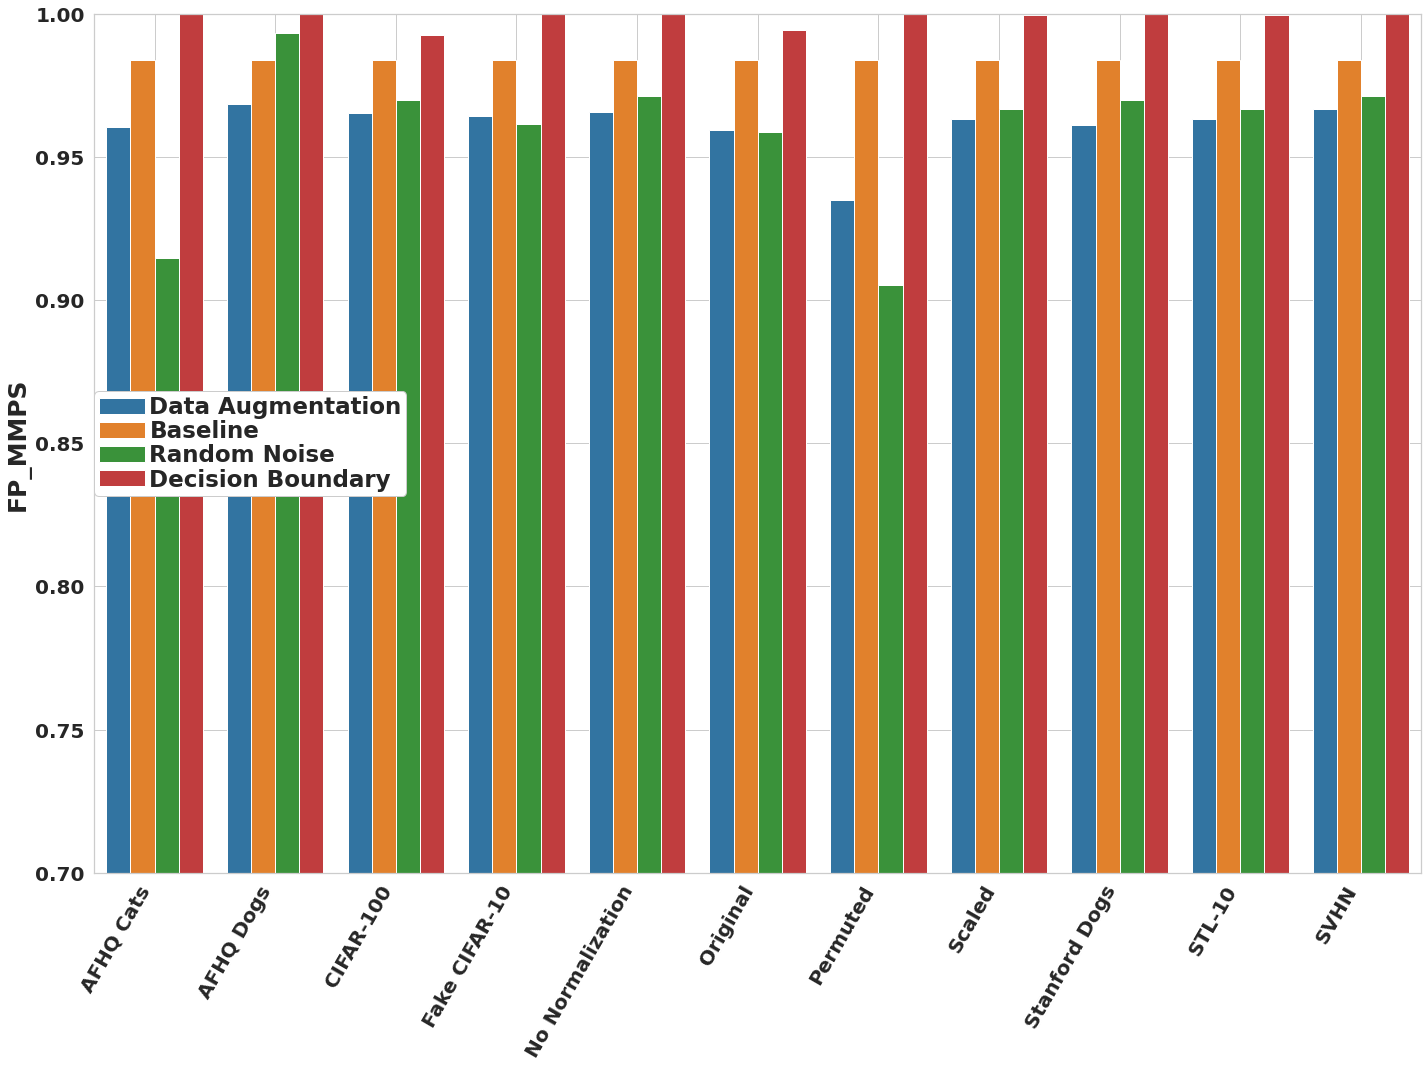

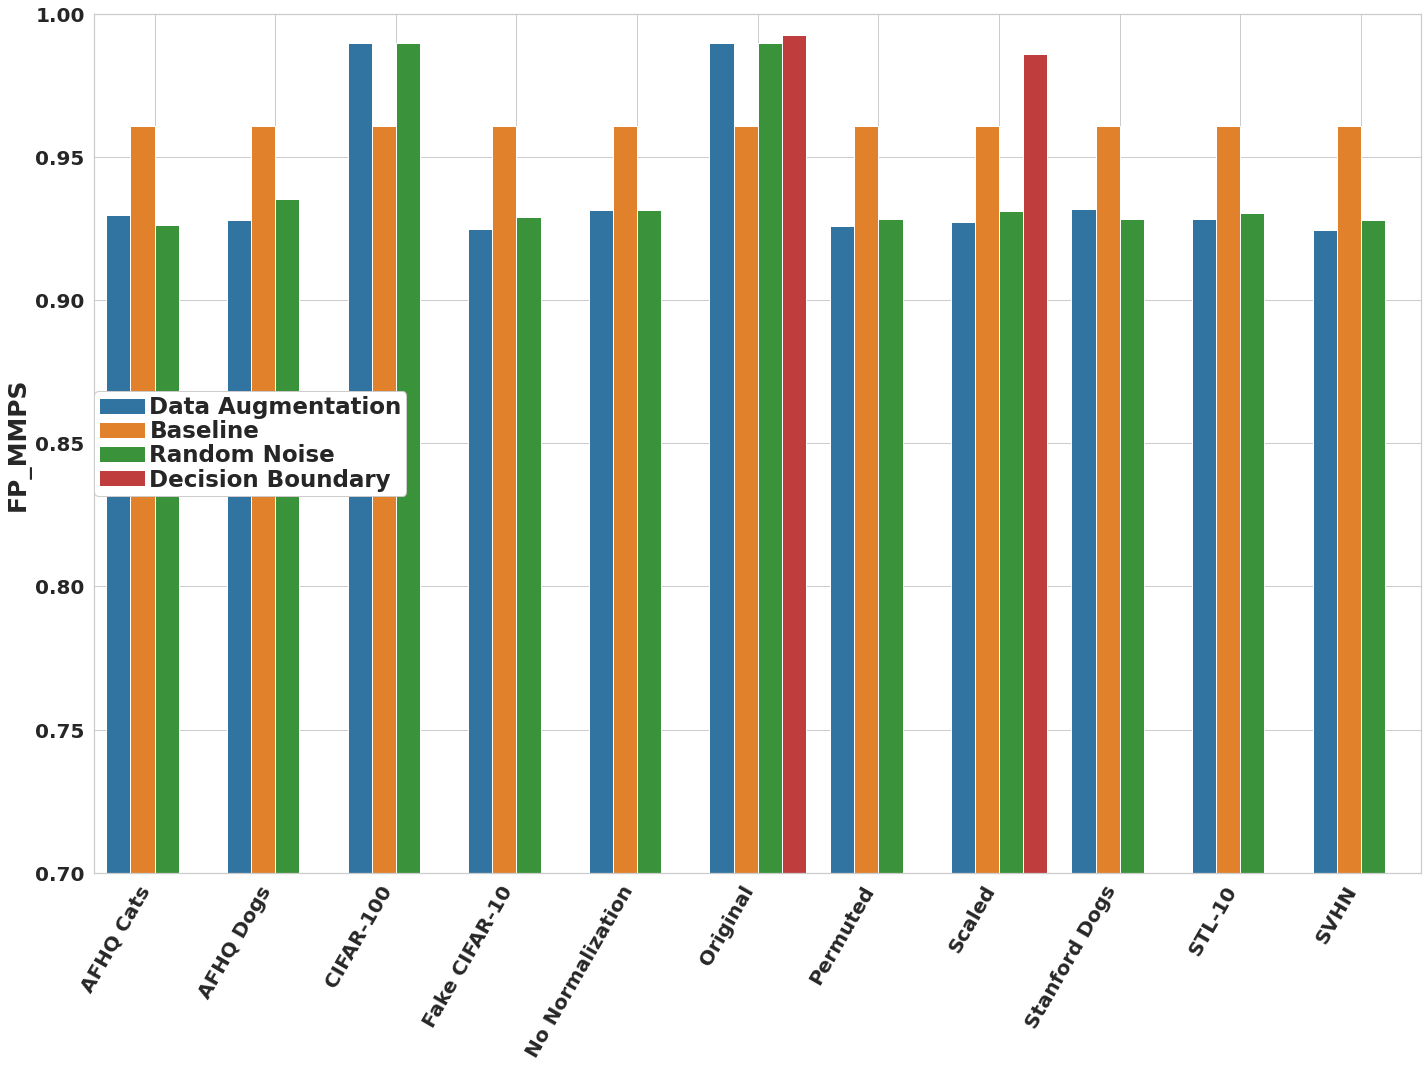

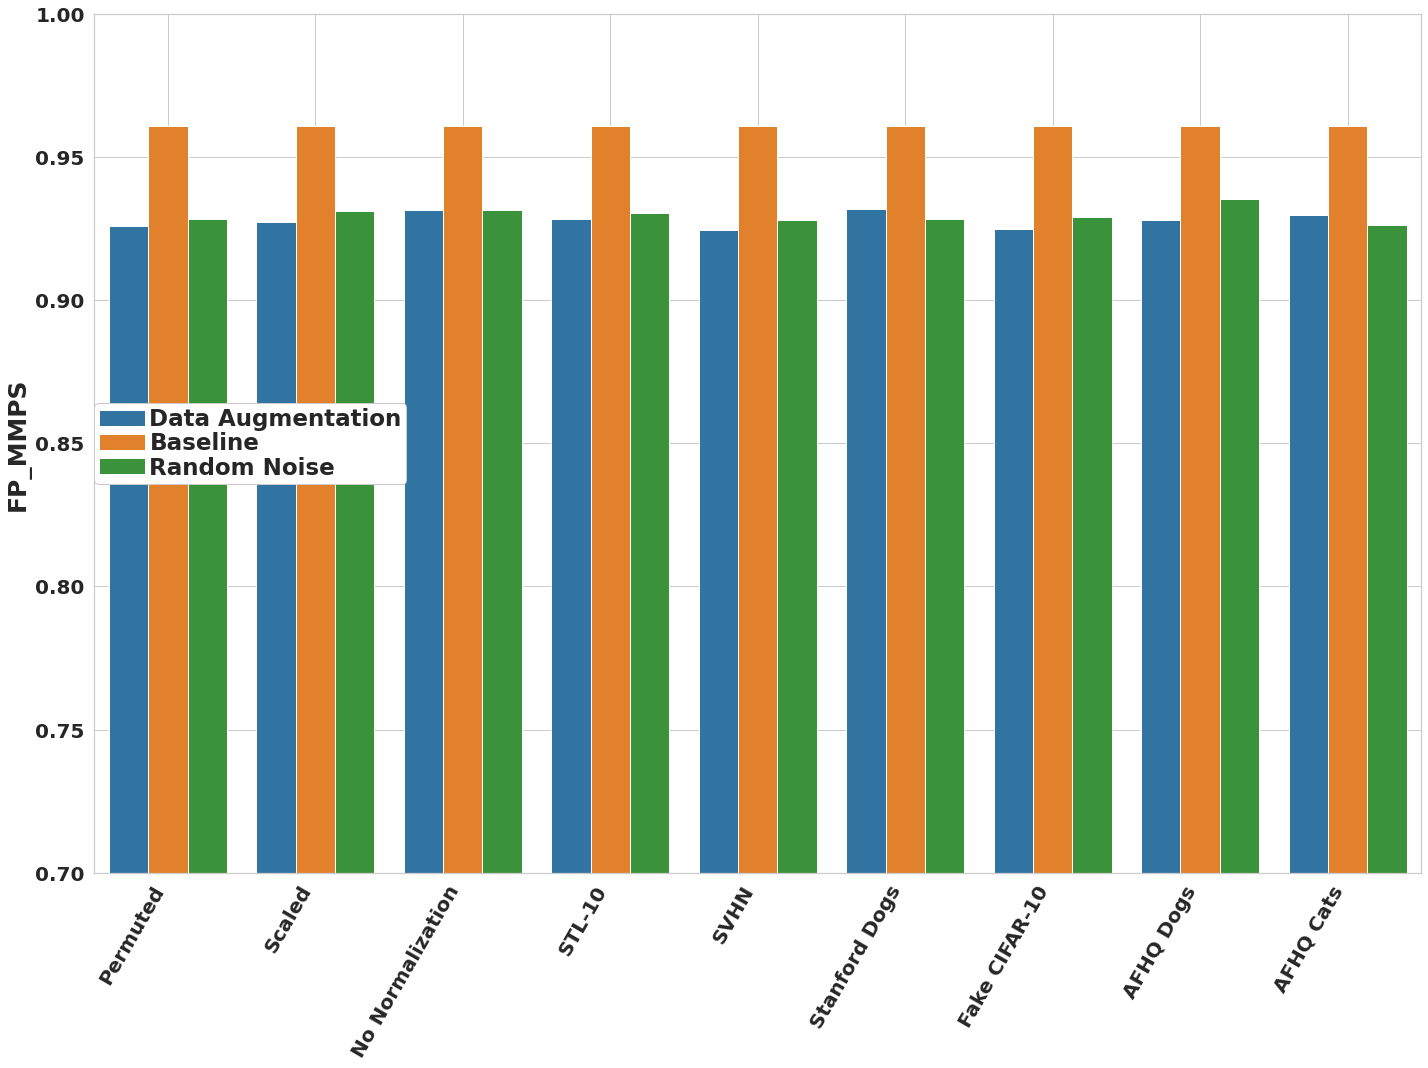

In [6]:
models = ["resnet18","salem_cnn_relu", "efficient_net", "efficient_net_LS"]
for model in models:
    print(model)
    df = get_cleaned_dataframe('../results/'+model+'_attack_results.csv')
    df = pd.melt(df, id_vars=['Dataset'], var_name='Attack', value_name='FP_MMPS')
    ax = plot_dataframe(df)
    fig = ax.get_figure()
    plt.tight_layout()
    fig.savefig(model+'_attack_results_scores.pdf')
